<a href="https://colab.research.google.com/github/peterbabulik/synthetic/blob/main/AntenaCallculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimizing antenna:   2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

Generation 0: Best fitness = 0.9179


Optimizing antenna:  22%|██▏       | 11/50 [00:09<00:34,  1.12it/s]

Generation 10: Best fitness = 0.9465


Optimizing antenna:  42%|████▏     | 21/50 [00:17<00:22,  1.30it/s]

Generation 20: Best fitness = 0.9469


Optimizing antenna:  62%|██████▏   | 31/50 [00:26<00:14,  1.27it/s]

Generation 30: Best fitness = 0.9471


Optimizing antenna:  82%|████████▏ | 41/50 [00:34<00:08,  1.09it/s]

Generation 40: Best fitness = 0.9471


Optimizing antenna: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


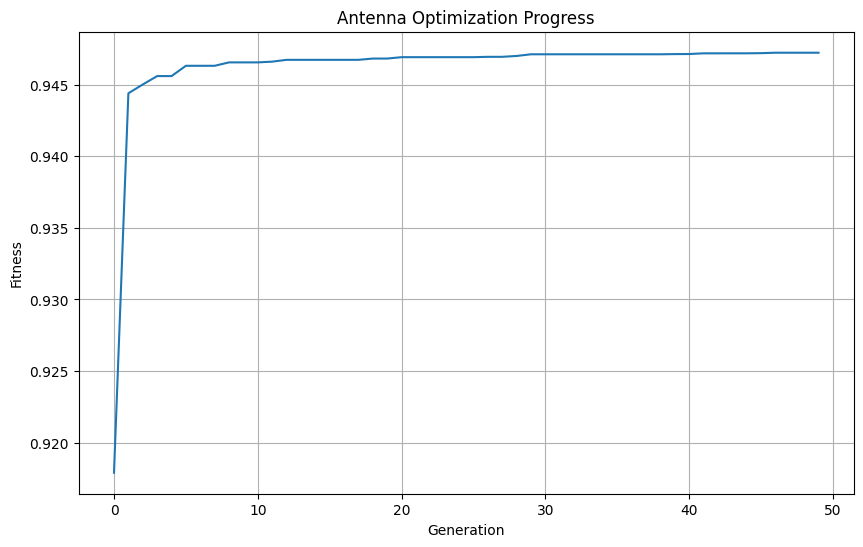


Best antenna configuration found:

Element 1:
Position: (0.047758736881473654, 0.03548879415985791, 0.042156100928406604)
Length: 0.053 m
Radius: 0.001297 m
Phase shift: 1.51 rad

Element 2:
Position: (-0.01246786854846587, 0.009334098081234816, 0.004614001550759064)
Length: 0.054 m
Radius: 0.000915 m
Phase shift: 6.22 rad

Element 3:
Position: (-0.05769081670977022, -0.015283166266517129, 0.012016052377551423)
Length: 0.054 m
Radius: 0.001607 m
Phase shift: 5.43 rad

Element 4:
Position: (-0.06250139844348439, -0.029206772449811083, -0.00577224994518984)
Length: 0.056 m
Radius: 0.000962 m
Phase shift: 4.27 rad

Final fitness: 0.9472
Input impedance: 56.0 ohms


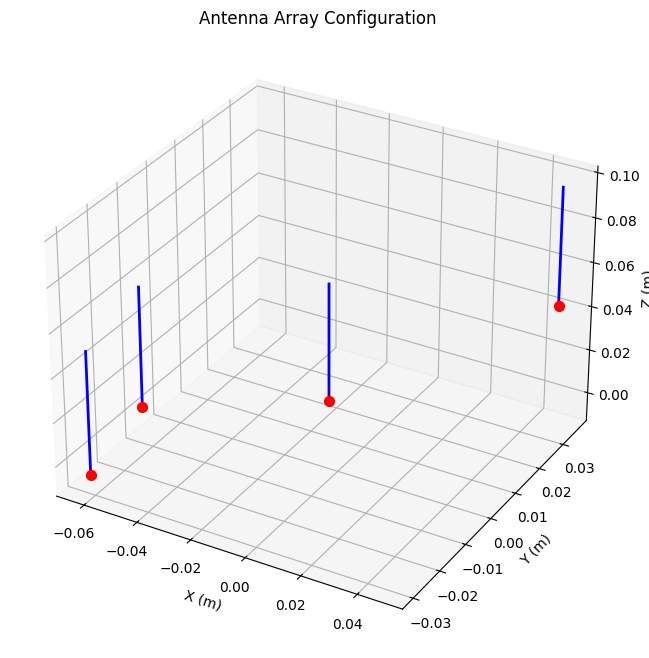

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple, Dict
import random
from tqdm import tqdm
import scipy.constants as const

class AntennaElement:
    def __init__(self,
                 position: Tuple[float, float, float],
                 length: float,
                 radius: float,
                 material_conductivity: float,
                 phase_shift: float = 0.0):
        # Enforce minimum and maximum values for physical parameters
        self.position = position
        self.length = np.clip(length, 1e-3, 1.0)  # Limit length between 1mm and 1m
        self.radius = np.clip(radius, 1e-4, 0.1)  # Limit radius between 0.1mm and 10cm
        self.material_conductivity = np.clip(material_conductivity, 1e6, 6e7)  # Copper conductivity range
        self.phase_shift = phase_shift % (2 * np.pi)  # Normalize phase shift to [0, 2π]

class AntennaArray:
    def __init__(self, elements: List[AntennaElement]):
        self.elements = elements
        self.frequency = 2.4e9  # Default to 2.4 GHz
        self.wavelength = const.c / self.frequency
        self.fitness = 0.0

    def calculate_directivity(self, theta: float, phi: float) -> float:
        """Calculate directivity pattern at given angles with numerical stability."""
        k = 2 * np.pi / self.wavelength
        total_field = 0j

        # Add small epsilon to prevent division by zero
        eps = 1e-10
        theta = np.clip(theta, eps, np.pi - eps)

        for element in self.elements:
            x, y, z = element.position
            phase = k * (x * np.sin(theta) * np.cos(phi) +
                        y * np.sin(theta) * np.sin(phi) +
                        z * np.cos(theta))

            # Element factor with numerical stability
            cos_term = np.cos(np.pi/2 * np.cos(theta))
            sin_term = np.sin(theta)

            # Avoid division by zero and handle edge cases
            if abs(sin_term) < eps:
                element_factor = 1.0 if abs(cos_term) < eps else 0.0
            else:
                element_factor = cos_term / sin_term

            # Limit the maximum value of element factor
            element_factor = np.clip(element_factor, -1e3, 1e3)

            # Add element contribution with its phase shift
            field_contribution = element_factor * np.exp(1j * (phase + element.phase_shift))
            total_field += field_contribution

        # Return power pattern with numerical bounds
        return np.clip(np.abs(total_field) ** 2, 0, 1e6)

    def calculate_impedance(self) -> complex:
        """Calculate input impedance with numerical stability."""
        Z0 = 377.0  # Free space impedance
        total_Z = 0j

        for element in self.elements:
            beta = 2 * np.pi / self.wavelength
            length_ratio = element.length / self.wavelength

            # Bounded impedance calculation
            R_rad = np.clip(73.0 * (length_ratio / 0.5) ** 2, 1.0, 1000.0)
            X = np.clip(42.5 * np.cos(beta * element.length / 2), -1000.0, 1000.0)

            # Add material losses with bounds
            skin_depth = np.sqrt(2 / (2 * np.pi * self.frequency * const.mu_0 * element.material_conductivity))
            R_loss = np.clip(
                element.length / (2 * np.pi * element.radius * element.material_conductivity * skin_depth),
                0.0, 100.0
            )

            Z_element = complex(R_rad + R_loss, X)
            total_Z += Z_element

        # Return average impedance with bounds
        Z_avg = total_Z / len(self.elements)
        return complex(
            np.clip(Z_avg.real, 1.0, 1000.0),
            np.clip(Z_avg.imag, -1000.0, 1000.0)
        )

class AntennaOptimizer:
    def __init__(self,
                 population_size: int = 50,
                 mutation_rate: float = 0.2,
                 target_frequency: float = 2.4e9):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.target_frequency = target_frequency
        self.target_impedance = 50.0  # Standard 50 ohm target
        self.wavelength = const.c / target_frequency

    def generate_random_antenna(self, num_elements: int) -> AntennaArray:
        elements = []
        max_spacing = self.wavelength # Maximum element spacing of one wavelength

        for _ in range(num_elements):
            position = (
                random.uniform(-max_spacing/2, max_spacing/2),
                random.uniform(-max_spacing/2, max_spacing/2),
                random.uniform(0, max_spacing/2)
            )
            length = random.uniform(0.1, 0.5) * self.wavelength
            radius = random.uniform(0.001, 0.01) * self.wavelength
            conductivity = random.uniform(1e6, 6e7)  # Range from poor to good conductor
            phase_shift = random.uniform(0, 2 * np.pi)

            elements.append(AntennaElement(position, length, radius, conductivity, phase_shift))

        return AntennaArray(elements)

    def calculate_fitness(self, antenna: AntennaArray) -> float:
        try:
            # Calculate directivity at key angles
            theta_samples = np.linspace(0.01, np.pi/2 - 0.01, 10)  # Avoid 0 and π/2
            phi_samples = np.linspace(0, 2*np.pi, 20)

            directivities = []
            for theta in theta_samples:
                for phi in phi_samples:
                    directivity = antenna.calculate_directivity(theta, phi)
                    if np.isfinite(directivity):
                        directivities.append(directivity)

            if not directivities:
                return 0.0

            max_directivity = np.max(directivities)

            # Calculate impedance matching
            Z_in = antenna.calculate_impedance()
            if not np.isfinite(Z_in):
                return 0.0

            reflection_coeff = abs((Z_in - self.target_impedance)/(Z_in + self.target_impedance))
            reflection_coeff = np.clip(reflection_coeff, 0, 0.999)  # Avoid division by zero in VSWR
            vswr = (1 + reflection_coeff) / (1 - reflection_coeff)

            # Normalize and combine metrics
            directivity_score = np.clip(max_directivity / (4 * np.pi), 0, 1)
            vswr_score = np.clip(1 / vswr, 0, 1)

            return 0.7 * directivity_score + 0.3 * vswr_score

        except Exception as e:
            print(f"Fitness calculation error: {e}")
            return 0.0

    def mutate_antenna(self, antenna: AntennaArray) -> AntennaArray:
        new_elements = []
        for element in antenna.elements:
            if random.random() < self.mutation_rate:
                # Mutate position with bounds
                max_move = self.wavelength / 4
                new_pos = tuple(
                    p + random.uniform(-max_move, max_move)
                    for p in element.position
                )

                # Mutate length
                new_length = element.length * (1 + random.gauss(0, 0.1))

                # Mutate radius
                new_radius = element.radius * (1 + random.gauss(0, 0.1))

                # Mutate phase
                new_phase = (element.phase_shift + random.gauss(0, 0.2)) % (2 * np.pi)

                new_elements.append(AntennaElement(
                    new_pos, new_length, new_radius,
                    element.material_conductivity, new_phase
                ))
            else:
                new_elements.append(element)

        return AntennaArray(new_elements)

    # (crossover, optimize, plot_optimization_progress, and visualize_antenna methods)
    def crossover(self, parent1: AntennaArray, parent2: AntennaArray) -> AntennaArray:
        n_elements = len(parent1.elements)
        split_point = random.randint(1, n_elements - 1)
        child_elements = parent1.elements[:split_point] + parent2.elements[split_point:]
        return AntennaArray(child_elements)

    def optimize(self, num_elements: int, generations: int = 100) -> AntennaArray:
        population = [self.generate_random_antenna(num_elements)
                     for _ in range(self.population_size)]
        best_fitnesses = []

        for generation in tqdm(range(generations), desc="Optimizing antenna"):
            # Evaluate fitness
            for antenna in population:
                antenna.fitness = self.calculate_fitness(antenna)

            # Sort by fitness
            population.sort(key=lambda x: x.fitness, reverse=True)
            best_antenna = population[0]

            if np.isfinite(best_antenna.fitness):
                best_fitnesses.append(best_antenna.fitness)

            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_antenna.fitness:.4f}")

            # Create new population
            new_population = population[:self.population_size // 4]

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate_antenna(child)
                new_population.append(child)

            population = new_population

        self.plot_optimization_progress(best_fitnesses)
        return population[0]

    def plot_optimization_progress(self, fitnesses):
        if fitnesses:  # Only plot if we have valid fitness values
            plt.figure(figsize=(10, 6))
            plt.plot(fitnesses)
            plt.title('Antenna Optimization Progress')
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.grid(True)
            plt.show()

    def visualize_antenna(self, antenna: AntennaArray):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot elements
        for element in antenna.elements:
            x, y, z = element.position
            length = element.length

            # Plot element as a line
            ax.plot([x, x], [y, y], [z, z + length], 'b-', linewidth=2)
            ax.scatter(x, y, z, c='r', s=50)

        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('Antenna Array Configuration')
        plt.show()

# Example usage
def main():
    # Create optimizer for 2.4 GHz antenna
    optimizer = AntennaOptimizer(population_size=50,
                               mutation_rate=0.2,
                               target_frequency=2.4e9)

    # Optimize a 4-element antenna array
    best_antenna = optimizer.optimize(num_elements=4, generations=50)

    if best_antenna.fitness > 0:
        print("\nBest antenna configuration found:")
        for i, element in enumerate(best_antenna.elements):
            print(f"\nElement {i+1}:")
            print(f"Position: {element.position}")
            print(f"Length: {element.length:.3f} m")
            print(f"Radius: {element.radius:.6f} m")
            print(f"Phase shift: {element.phase_shift:.2f} rad")

        print(f"\nFinal fitness: {best_antenna.fitness:.4f}")
        Z_in = best_antenna.calculate_impedance()
        print(f"Input impedance: {abs(Z_in):.1f} ohms")

        # Visualize the antenna
        optimizer.visualize_antenna(best_antenna)

if __name__ == "__main__":
    main()